# First Approach: seq2seq and fuzzy

In [2]:
import pandas as pd
from time import time

#  this data was gathered from Kaggle database
data = pd.read_csv('data.csv', encoding='iso-8859-1')


 The data has two columns, "headlines" and "text".
 The goal is to use seq2seq model to summarize the text further in a way that has the same length as the headline. This summarization helps the matching model a lot in order to find the best sentimentm matching of the text with targeted headline

In [3]:
data.head(5)

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [4]:
# the text_cleaning funcion helps to remove the non-alphabetic characters
# from the data set and 
import re
def text_cleaning(column):
    for row in column:
        
        row=re.sub("(\\t)", ' ', str(row)).lower() 
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()  
        row=re.sub("(--+)", ' ', str(row)).lower() 
        row=re.sub("(~~+)", ' ', str(row)).lower()   
        row=re.sub("(\+\++)", ' ', str(row)).lower()  
        row=re.sub("(\.\.+)", ' ', str(row)).lower()  
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() 
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() 
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() 
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() 
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() 
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() 
        row=re.sub("(\-\s+)", ' ', str(row)).lower()
        row=re.sub("(\:\s+)", ' ', str(row)).lower() 
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() 
        
        #Replace https://abc.xyz.net/site/site ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass 
        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        yield row


In [5]:
text = text_cleaning(data['text'])
headline = text_cleaning(data['headlines'])

In [6]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

t = time()

#Batch the data points into 5000 
text = [str(doc) for doc in nlp.pipe(text, batch_size=5000)]

#On my mac it takes 9-10 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

/Users/soroushrasti/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/soroushrasti/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/soroushrasti/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/soroushrasti/Library/Python/3.7/lib/

In [7]:
t = time()

#Batch the data points into 5000
headline = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(headline, batch_size=5000)]

#On my mac, it takes 2-3 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.48 mins


In [8]:
text[0]

'saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.'

In [9]:
headline[0]

'_START_ upgrad learner switches to career in ml al with 90% salary hike _END_'

In [10]:
data['cleaned_text'] = pd.Series(text)
data['cleaned_headline'] = pd.Series(headline)

In [11]:
text_count = []
headline_count = []

In [12]:
for sent in data['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in data['cleaned_headline']:
    headline_count.append(len(sent.split()))

In [13]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['headline']=headline_count

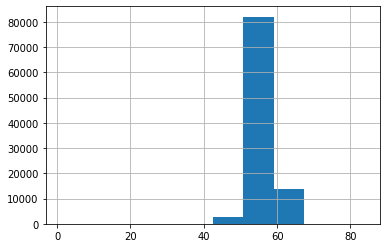

In [14]:
import matplotlib.pyplot as plt

graph_df['text'].hist()
plt.show()

As you see, the length of the text is between 40 and 70 words

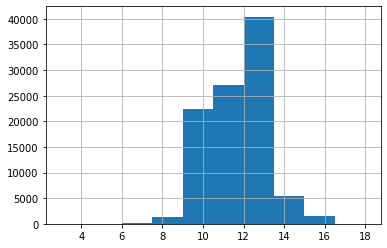

In [16]:
graph_df['headline'].hist()
plt.show()

The length of the headline is between 6 and 16 words

In [18]:
#Check how much percet of headline have a length 0-14 words
cnt=0
for i in data['cleaned_headline']:
    if(len(i.split())<=14):
        cnt=cnt+1
print(cnt/len(data['cleaned_headline']))

0.984481865021697


In [19]:
#Check how much percet of text have words between 0-62 words
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=62):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.9973780754260627


We just understood that most of the text has length between 8-15 words for headline and 40-100 words for text, therefore, for the model we can set the maximim length of each to the following

In [1]:
max_text_len=62
max_headline_len=14

Following the last argument, here, we cut down the length of text/headline in order to make sure all of the data has less than the pre-determined maximim words

In [21]:

import numpy as np
cleaned_text =np.array(data['cleaned_text'])
cleaned_headline=np.array(data['cleaned_headline'])

short_text=[]
short_headline=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_headline[i].split())<=max_headline_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_headline.append(cleaned_headline[i])
# put the new data in a new dataframe        
df=pd.DataFrame({'text':short_text,'headline':short_headline})

For a better performace of the model and in order to make the decoding/encoding easier, here, I added "sabbr" and "konnn" to first and end of the headline

In [22]:
df['headline'] = df['headline'].apply(lambda x : 'sabbr '+ x + ' konnn')

Spliting the data to train and validation sets

In [24]:
from sklearn.model_selection import train_test_split
x_train,x_validation,y_train,y_validation=train_test_split(np.array(df['text']),np.array(df['headline']),test_size=0.15,random_state=10,shuffle=True)

In [25]:
# here I want to get a sense of the size of data
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_train))

x_voc_all   =  len(x_tokenizer.word_counts) + 1

print("Number of all words in x_train = {}".format(x_voc_all))

Using TensorFlow backend.
Number of all words in x_train = 76892


The number of words is very large, here I should focus on the common words because the rare words do not imporve the performace of the model and just makes the calculation heavier

In [26]:
# number of times a word repeated is used to identify the common words
repeat=3

rare_words=0
all_words=0


for word,number in x_tokenizer.word_counts.items():
    all_words+=1
    if(number<repeat):
        rare_words+=1
    
print("percent of rare words in x:",(rare_words/all_words)*100)

percent of rare words in x: 50.550779675124524


As see from before over 50 percent of data are rare words, let's limit the data to only the common words in order to speed up the calculation

In [27]:

x_tokenizer = Tokenizer(num_words=all_words-rare_words) 
x_tokenizer.fit_on_texts(list(x_train))

#one of the steps for feeding the data into the model is to
# convert the text to integer sequences and padding zero of the length of data is less than 
# the maximim value, in this way all the data would have the same length

#convert text sequences into integer sequences 
x_train_seq    =   x_tokenizer.texts_to_sequences(x_train) 
x_validation_seq   =   x_tokenizer.texts_to_sequences(x_validation)

#padding zero up to maximum length
x_train   =   pad_sequences(x_train_seq,  maxlen=max_text_len, padding='post')
x_validation   =   pad_sequences(x_validation_seq, maxlen=max_text_len, padding='post')

#size of common vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Number of common words in x_train = {}".format(x_voc))


Number of common words in x_train = 38023


In [28]:
# the same as before but for Y
y_tokenizer = Tokenizer() 
y_tokenizer.fit_on_texts(list(y_train))

y_voc_all   =  len(y_tokenizer.word_counts) + 1

print("Number of all words in y_train = {}".format(y_voc_all))

Number of all words in y_train = 33483


In [29]:
# the same as before but for Y

# the number of words is very huge, here I should focus on the 
# common words because the rare words does not imporve the performace and just
# make the calculation heavier

# number of times a word repeated to count as common word
repeat=3

rare_words=0
all_words=0


for word,number in y_tokenizer.word_counts.items():
    all_words+=1
    if(number<repeat):
        rare_words+=1
    
print("percent of rare words in y:",(rare_words/all_words)*100)

percent of rare words in y: 50.29568126157338


In [30]:
# the same as before but for Y
y_tokenizer = Tokenizer(num_words=all_words-rare_words) 
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_train_seq    =   y_tokenizer.texts_to_sequences(y_train) 
y_validation_seq   =   y_tokenizer.texts_to_sequences(y_validation) 

#padding zero upto maximum length
y_train    =   pad_sequences(y_train_seq, maxlen=max_headline_len, padding='post')
y_validation   =   pad_sequences(y_validation_seq, maxlen=max_headline_len, padding='post')

#size of vocabulary ( +1 for padding token)
y_voc   =  y_tokenizer.num_words + 1

print("Number of common words in x_train= {}".format(y_voc))

Number of common words in x_train= 16643


It turns out that some of the headlines are empty, here we remove those ones

In [31]:

# those ome with "START" and "END" has only two words
ind=[]
for i in range(len(y_train)):
    cnt=0
    for j in y_train[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_train=np.delete(y_train,ind, axis=0)
x_train=np.delete(x_train,ind, axis=0)

In [32]:
ind=[]
for i in range(len(y_validation)):
    cnt=0
    for j in y_validation[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_validation=np.delete(y_validation,ind, axis=0)
x_validation=np.delete(x_validation,ind, axis=0)

### Until now, we perpared and processed the data for feeding to the model, from here, the modeling part starts

![Loss](seq2seq-1.png)

here in each step, the encode, embeding layer, encoders and dense layers are definded based on the size of healines and text as discussed before

In [34]:

from keras import backend 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


backend.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding 
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder
decoder_inputs = Input(shape=(None,))

#embedding 
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense 
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# summary of the model artichecture
model.summary()





Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 62)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 62, 200)      7604600     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 62, 300), (N 601200      embedding[0][0]                  
_____________________________________________________

In [35]:
# compile the model with "rmsprop" optimizer which seems to works good here
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [36]:
# this useful to avoid overfiting and reduce the computational cost a lot
earltstoping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


here the model is fitted to the train data with early stoping condition on the loss of validation set.
After a little experimenting, it is found that it is better to set bach_size to 500. This large value of bach_size is just because of the low performance of my macbook although this size of batch_size affects negatively the quality of training.
I also set the epoches to 4 because my pc could not calculate more and would takes a lot of time.
With this setting,the quality of trining drops down significantly. I should note that the usual number of epoches is between 60 and 100.

In [38]:

output=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=4,callbacks=[earltstoping],batch_size=500, validation_data=([x_validation,y_validation[:,:-1]], y_validation.reshape(y_validation.shape[0],y_validation.shape[1], 1)[:,1:]))

Train on 82138 samples, validate on 14496 samples
Epoch 1/4
82138/82138 [==============================] - 3106s 38ms/sample - loss: 5.5280 - val_loss: 5.3584
Epoch 2/4
82138/82138 [==============================] - 3693s 45ms/sample - loss: 5.3455 - val_loss: 5.2155
Epoch 3/4
82138/82138 [==============================] - 3453s 42ms/sample - loss: 5.1574 - val_loss: 5.0152
Epoch 4/4
82138/82138 [==============================] - 3369s 41ms/sample - loss: 4.9378 - val_loss: 4.8285


let's visualzise the the performace of the model for both validation and training


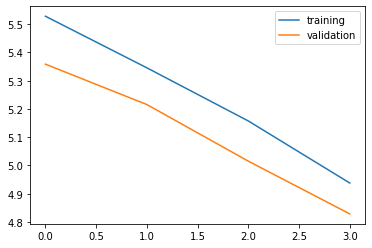

In [39]:

from matplotlib import pyplot
pyplot.plot(output.history['loss'], label='training')
pyplot.plot(output.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [40]:
# for more convience of transforming index to word and vice versa
# here, three dictionaries are defined
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [41]:
# Encode the input sequence 
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer 
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

I used this function for the inference processes purposes

In [56]:

def decode_sequence(input_seq):
    # Encode the input 
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Empty target 
    target_seq = np.zeros((1,1))
    
    # Populate with the start word.
    target_seq[0, 0] = target_word_index['sabbr']

    stop = False
    decoded_sentence = ''
    while not stop:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # find the most probable tocken
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='konnn'):
            decoded_sentence += ' '+sampled_token

        # test whether it is time to finish the process
        if (sampled_token == 'konnn'  or len(decoded_sentence.split()) >= (max_headline_len-1)):
            stop = True

        # Update the target sequence
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [48]:
# A function to convert an integer sequence to a word sequence for headline as well as the text
def seq2headline(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0 and i!=target_word_index['sabbr']) & (i!=target_word_index['konnn']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Now it is time to take one step further and define a new dataframe that has an additional column named "predicted_headline" which has the same length as the "orginal headline" column. 
"predicted_headline" column helps the matching model signifucanyl to find and rank the news article headline to the orginal text.
As explained before, because of the limited resources I had, the model was fitted to the data very poorly, so the bad performance and bad matching between the "predicted_headline" and "original_headline" was expected. Here, the purpose of the notebook is to show the approach, so my appolgies if my resources was limited and could not fit very well the model to the data


In [96]:

df=pd.DataFrame(columns=["original_headline","text","predicted_headline"])
for i in range(0,x_train.shape[0]):
  df.loc[i,"text"]=seq2text(x_train[i])
  df.loc[i,"original_headline"]=seq2headline(y_train[i]).replace("start"," ",1).replace("end"," ",1)
  df.loc[i,"predicted_headline"]=decode_sequence(x_train[i].reshape(1,max_text_len)).replace("start"," ",1).replace("end"," ",1)
df.head(1)

,original_headline,text,predicted_headline
0,russia asks twitter users which us consulate they want shut,after the us closed the russian consulate in seattle the russian embassy in the us tweeted what us consulate general would you close in russia if it was up to you to decide the poll which lists th...,trump to be in india to be in us


#### Text sentiment matching 

Now, we are very close to the final results.
In this step, we just want to find the semantic similarity between the predcited_headline and the orginal headlines and rank them according to their relevence.
Here, **k** is a parameter that determines how many relevant orginal_headline the model should find.

#### fuzzywuzzy library
In this appraoch, I used the fuzzywuzzy library and rank the relevance of the headline according to the Levenshtein Distance

In [98]:

k=3
# for string matching I used fuzzywuzzy library
from fuzzywuzzy import fuzz

# a function that ranks the "k" best matches of "original_headline"s to the "predicted_headline"s
def ranking(predicted_headline):
    matches= df.apply(lambda row: fuzz.token_sort_ratio(row["original_headline"],predicted_headline), axis=1)
    # gives the index of k best matches
    return sorted(range(len(matches)), key= lambda i: matches[i], reverse=True )[:k]


In [99]:
# here, based on the ranking function, the k best matching headlines 
# are stored in the database

for i, predicted_headline in enumerate(df["predicted_headline"]):
    for rank, rank_index in enumerate(ranking(predicted_headline)):
        df.loc[i,"matching rank of "+ str(rank+1) ]= df.loc[rank_index,"original_headline"]

df.head(1)

,original_headline,text,predicted_headline,matching rank of 1,matching rank of 2,matching rank of 3
0,russia asks twitter users which us consulate they want shut,after the us closed the russian consulate in seattle the russian embassy in the us tweeted what us consulate general would you close in russia if it was up to you to decide the poll which lists th...,trump to be in india to be in us,indian it manager charged with insider trading in us,us turkey may come face to face in syria turkish deputy pm,indian billionaire to pay yr for freed inmates airfare


As you see from the first query, the performance of model is bad which just bacause of low number of epoches in the training part.

# Second appraoch: Gensim
This approach was somehow a backup plan since this implementation is a very quick and super straightforward.
In this section, I implement this approach the solve the whole problem at once. 

I should note that the Gensim method can also be used instead of fuzzy library introduced in the first part.

At first, we need to create a corpus to work with



In [1]:
from collections import defaultdict
from gensim import corpora
import pandas as pd
data = pd.read_csv('data.csv', encoding='iso-8859-1')
headlines=list(data["headlines"])[:10]

# remove common words and tokenize
stoplist = set('for a of the and to in'.split())
texts = [
    [word for word in headlines.lower().split() if word not in stoplist]
    for headlines in headlines
]

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

I use this corpus to define a 2-dimensional LSI space.
here I also index the corpus to prepare for similarity test.



In [2]:
from gensim import models
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=2)
from gensim import similarities
index = similarities.MatrixSimilarity(lsi[corpus])  # transform corpus to LSI space and index it

create a dataframe to save the results of gensim

In [3]:
df_gensim=data.copy()[:10]

We would like to sort our nine headlines  in decreasing order of relevance to texts. 

In [4]:
from gensim import similarities

summrized_texts = list(data["text"])[:10]
for i, text in enumerate(summrized_texts):
    vec_bow = dictionary.doc2bow(text.lower().split())
    vec_lsi = lsi[vec_bow]  # convert the query to LSI space
    sims = index[vec_lsi]  # perform a similarity query against the corpus
    # sort these similarities into descending order, and obtain the final answer to the headline
    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    rank=1
    for headline_position, headline_score in sims:
        df_gensim.loc[i,"matching rank of "+ str(rank) ]= df_gensim.loc[headline_position,"headlines"]
        rank+=1
df_gensim.head(1)

,headlines,text,matching rank of 1,matching rank of 2,matching rank of 3,matching rank of 4,matching rank of 5,matching rank of 6,matching rank of 7,matching rank of 8,matching rank of 9,matching rank of 10
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...,Delhi techie wins free food from Swiggy for on...,New Zealand end Rohit Sharma-led India's 12-ma...,Aegon life iTerm insurance plan helps customer...,"Have known Hirani for yrs, what if MeToo claim...",Rahat Fateh Ali Khan denies getting notice for...,"India get all out for 92, their lowest ODI tot...",Govt directs Alok Verma to join work 1 day bef...,Called PM Modi 'sir' 10 times to satisfy his e...,"Cong wins Ramgarh bypoll in Rajasthan, takes t..."


Recall@k is calculated by the following formula:

![Loss](recall-1.png)

or: Recall is the fraction of the documents that are relevant to the query that are successfully retrieved.

Therefore, from the first query shown above, one can calculate that based on the fact that the only relevent item is ranked first.

recall@1= 1 as the desired item is avialble in the first place

recall@10= 1 again because the desired item is avialble in the first place

recall@30= 1 again because the desired item is avialble in the first place

# Third approach: gensim with more data cleaning 
preprocessing in gensim, and also remove any HTML tags and ..

In [9]:
from re import sub
from gensim.utils import simple_preprocess

documents  = list(data["headlines"])[:10]
query_strings = list(data["text"])[:10]

stopwords = ['the', 'and', 'are', 'a']

def preprocess(doc):
    # Tokenize, clean up input document string
    doc = sub(r'<img[^<>]+(>|$)', " image_token ", doc)
    doc = sub(r'<[^<>]+(>|$)', " ", doc)
    doc = sub(r'\[img_assist[^]]*?\]', " ", doc)
    doc = sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', " url_token ", doc)
    return [token for token in simple_preprocess(doc, min_len=0, max_len=float("inf")) if token not in stopwords]

# Preprocess the documents, including the query string
corpus = [preprocess(document) for document in documents]
queries = [preprocess(query_string) for query_string in query_strings] 

create a similarity matrix, that contains the similarity between each pair of words

In [ ]:

import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import WordEmbeddingSimilarityIndex
from gensim.similarities import SparseTermSimilarityMatrix
from gensim.similarities import SoftCosineSimilarity

glove = api.load("glove-wiki-gigaword-50")    
similarity_index = WordEmbeddingSimilarityIndex(glove)

# build the term dictionary, TF-idf model
dictionary = Dictionary(corpus+queries)
tfidf = TfidfModel(dictionary=dictionary)

# create the term similarity matrix.  
similarity_matrix = SparseTermSimilarityMatrix(similarity_index, dictionary, tfidf)


Finally, we calculate the soft cosine similarity between the text and each of the headlines

In [ ]:

for query in queries:
    query_tf = tfidf[dictionary.doc2bow(query)]

    index = SoftCosineSimilarity(
            tfidf[[dictionary.doc2bow(document) for document in corpus]],
            similarity_matrix)

    doc_similarity_scores = index[query_tf]

    # Output the sorted similarity headline and text
    sorted_indexes = np.argsort(doc_similarity_scores)[::-1]
    for headline_index in sorted_indexes:
        df_gensim.loc[i,"matching rank of "+ str(headline_index) ]= df_gensim.loc[headline_index,"original_headline"]




# Results
The result of the last model was best, which makes sense because in there, I used the most standard precedure.

# Other evaluation metrics

#### 1. Precision@kPermalink
This metric quantifies how many items in the top-K results were relevant. 

#### 2. Recall@kPermalink
This metric gives how many actual relevant results were shown out of all actual relevant results for the query. 

#### 3. F1@kPermalink
This is a combined metric that incorporates both Precision@k and Recall@k by taking their harmonic mean.

#### 4. Mean Reciprocal Rank(MRR)Permalink
This metric is useful when we want our system to return the best relevant item and want that item to be at a higher position. 

#### 5. Average Precision(AP)Permalink
Average Precision is a metric that evaluates whether all of the ground-truth relevant items selected by the model are ranked higher or not.

#### 6. Mean Average Precision(MAP)Permalink
If we want to evaluate average precision across multiple queries, we can use the MAP. It is simply the mean of the average precision for all queries.




# Some comments

all models can capture the semantic meaning and are not relying on just word overlapping. Also, regarding the length of the query, there is not limitation. For example in the first model, if the length is smaller than the defined threshold, in the preprocessing step we will fill it the rest with padding character.

# Next stpes
Of course, this notebook is not the most complete and best approach. I think it would be good to try other deepn naural network matching libraries such as matchzooit. Of course, fine-tuning the *Bert* model is also one of my favourite approaches. Also, here, I only decompose dataset into training and validation. But, for the future I will also decompse into the testing. This makes the evaluation more accurate because then the dataset that are evalueted are unseen to the model.